In [1]:
using Distributions
using StableDistributions#needed for levy alpha stable
using DataFrames
using XLSX#reading excel files
using DSP
using Plots

In [2]:
using LinearAlgebra
#
function centered(arr, newshape)
    # Convert newshape to an array
    #newshape = size(newshape)
    #we do our computations between tuple
    
    # Get the current shape of the array
    currshape = size(arr)
    
    # Calculate start and end indices for slicing
    startind = (currshape .- newshape) .÷ 2 .+ 1
    endind = startind .+ newshape .- 1
    
    # Create the slice objects
    slices = Tuple(startind[i]:endind[i] for i in 1:length(endind))
    
    # Return the centered portion of the array
    return arr[slices...]
end
#
function centered_convolve(signal1, signal2)#return convolution centered with repest to signal1 -> it is equal to scipy.stats.fftconvolve(mode="same")
    ret = conv(signal1,signal2)
    return centered(ret, size(signal1))
end

centered_convolve (generic function with 1 method)

In [97]:
function dirac_generator(fo_rate, gen_active_power)
    # Parameters for the first Dirac delta
    μ1 = 0  # Mean
    σ1 = 0.01  # Standard deviation (very small for approximation)
    desired_peak_value1 = 1-fo_rate
    
    # Parameters for the second Dirac delta
    μ2 = gen_active_power  # Mean
    σ2 = 0.01  # Standard deviation (very small for approximation)
    desired_peak_value2 = fo_rate
    
    # Generate data for the first Dirac delta
    dirac1 = Normal(μ1, σ1)
    
    # Generate data for the second Dirac delta
    dirac2 = Normal(μ2, σ2)
    # Generate sample points
    x = collect(range(-500, stop=500, step=0.1))
    y1 = pdf.(dirac1, x)
    y1 = (y1 ./ maximum(y1)) .*desired_peak_value1
    #
    y2 = pdf.(dirac2, x)
    y2 = (y2 ./ maximum(y2)) .*desired_peak_value2
    #
    return y1 + y2
    # Convolve the two functions
    #conv_result = convolve(dirac1, dirac2)  # 'shape=1' for 'same' convolution
    #conv_result = pdf.(conv_result, x)
    # Plot the results
    #plot(x, y1, label="Dirac Delta 1", title="Convolution of Two Dirac Delta Functions")
    #plot!(x, y2, label="Dirac Delta 2")
    #plot!(x, conv_result, label="Convolution Result")
end

dirac_generator (generic function with 1 method)

In [98]:
### read all datas in pdf and execute a recursive convolution
x = collect(range(-500, stop=500, step=0.1))
df = XLSX.readtable("data/gen_thermal_data.xlsx", "Worksheet") |> DataFrame
pmf1 = dirac_generator(df[2, :Forced_Outage], df[2, :P_MAX])
pmf2 = dirac_generator(df[3, :Forced_Outage], df[3, :P_MAX])
conv_pmf_fo = centered_convolve(pmf1,pmf2)
#conv_pmf_fo = conv_pmf_fo[1:length(pmf1)]
println("Sum of conv pmf: $(sum(conv_pmf_fo))")
#conv_pmf_fo = conv_pmf_fo/sum(conv_pmf_fo)
pmf = 0
for row in eachrow(df)
    pmf = dirac_generator(row.Forced_Outage, row.P_MAX)
    #pmf = pmf/sum(pmf)
    conv_pmf_fo = centered_convolve(conv_pmf_fo,pmf)
    #conv_pmf_fo = conv_pmf_fo[1:length(pmf1)]
    #conv_pmf_fo = conv_pmf_fo/sum(conv_pmf_fo)
    println("Sum of conv pmf: $(sum(conv_pmf_fo))")
end
#=x = np.linspace(-500, 500, 5000)
# Plotting
plt.plot(x, conv_pmf_fo)
plt.title('PMF of the Outage Rate of thermal Generation')
plt.xlabel('x')
plt.ylabel('Density')
plt.grid(True)
plt.show()=#

Sum of conv pmf: 0.9999999999999999
Sum of conv pmf: 1.0
Sum of conv pmf: 1.0
Sum of conv pmf: 1.0
Sum of conv pmf: 1.0000000000000004
Sum of conv pmf: 1.0000000000000007
Sum of conv pmf: 1.0000000000000004
Sum of conv pmf: 1.0000000000000007
Sum of conv pmf: 1.000000000000001
Sum of conv pmf: 1.0000000000000009
Sum of conv pmf: 1.0000000000000009
Sum of conv pmf: 1.0000000000000009
Sum of conv pmf: 1.0000000000000007
Sum of conv pmf: 1.0000000000000004
Sum of conv pmf: 1.0000000000000004
Sum of conv pmf: 1.0000000000000004
Sum of conv pmf: 1.0
Sum of conv pmf: 0.9999999999999997
Sum of conv pmf: 0.9999999999999996
Sum of conv pmf: 0.9999999999999997
Sum of conv pmf: 0.9999999999999993
Sum of conv pmf: 0.9999999999999992
Sum of conv pmf: 0.9999999999999989
Sum of conv pmf: 0.9999999999999987
Sum of conv pmf: 0.9999999999999984
Sum of conv pmf: 0.9999999999999984
Sum of conv pmf: 0.9999999999999981
Sum of conv pmf: 0.9999999999999983
Sum of conv pmf: 0.9999999999999982
Sum of conv pmf: 

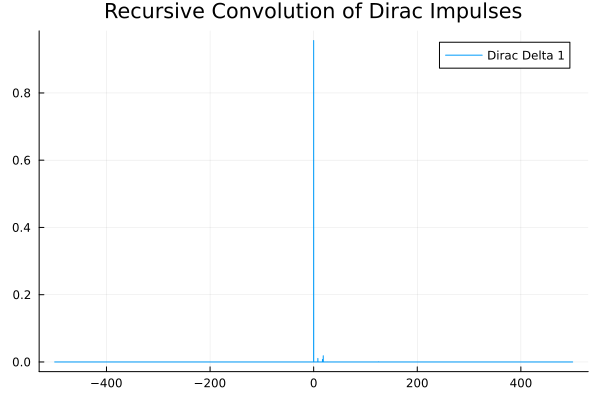

In [99]:
plot(x, conv_pmf_fo, label="Dirac Delta 1", title="Recursive Convolution of Dirac Impulses")

In [6]:
mutable struct Reserve
    percentile::Float64
    up::Float64
    down::Float64
    month::String
end

In [7]:
file_path = ["data/Ecart $(month) 2023.xlsx" for month in ["01 Janvier", "02 Février", "03 Mars", "04 Avril", "05 Mai", "06 Juin", "07 Juillet", "08 Aout", "09 Septembre", "10 Octobre", "11 Novembre", "12 Décembre"]];

In [105]:
function probabilistic_sizing(;pmf_fo, file, left_boundary = -500, right_boundary = 500, percentile = 0.95, month = "01 Janvier")
    df = XLSX.readtable(file, "Sheet1") |> DataFrame
    load_forecast_deviation = df[!, "Prévision Demande"]-df[!,"Réalisation Demande"]
    solar_forecast_deviation = df[!, "Prévision Solaire"]-df[!,"Réalisation Solaire"]
    wind_forecast_deviation = df[!, "Prévision éolienne"]-df[!,"Réalisation éolienne"]
    #
    load_error_dist = fit(Normal, load_forecast_deviation)
    solar_error_dist = fit(Normal, solar_forecast_deviation)
    wind_error_dist = fit(Stable, wind_forecast_deviation)
    #
    delta = 1e-1
    max = right_boundary
    min = left_boundary
    big_grid = collect(range(-500, stop=500, step=delta))
    #
    pmf1 = pdf.(load_error_dist, big_grid)*delta #we sample by multiplying with interval width
    println("Sum of load error pmf: $(sum(pmf1))")
    #
    pmf2 = pdf.(solar_error_dist, big_grid)*delta
    println("Sum of solar error pmf: $(sum(pmf2))")
    #
    pmf3 = pdf.(wind_error_dist, big_grid)*delta #we sample by multiplying with interval width
    println("Sum of wind error pmf: $(sum(pmf3))")
    #
    conv_pmf = centered_convolve(pmf1,pmf2)
    println("Sum of convoluted pmf load and solar: $(sum(conv_pmf))")
    #
    conv_pmf = centered_convolve(conv_pmf,pmf3)
    println("Sum of convoluted pmf with wind: $(sum(conv_pmf))")
    #
    conv_pmf = centered_convolve(conv_pmf,pmf_fo)
    println("Sum of convoluted pmf with outage: $(sum(conv_pmf))")
    #
    conv_pdf = conv_pmf/delta
    println("Integration of convoluted pdf: $(trapz(big_grid, conv_pdf))")
    #
    xx = yy = 0
    for k in range(1, length(big_grid))
        if k == 1
            xx = big_grid
            yy = conv_pdf
        else
            xx = big_grid[1:end-k]
            yy = conv_pdf[1:end-k]
        end
        v = trapz(xx, yy)
        #print(f"Integral {k} from {xx[0]} to {xx[-1]} is equal to {v}")
        if v <= percentile
            break
        end
    end
    #
    println("Une réserve positive de $(round(xx[end], digits = 2)) MW")
    up = round(xx[end], digits = 2)
    # now compute integral cutting left limit down by one
    # with each iteration, stop as soon as we hit the oercentile value
    for k in range(1, length(big_grid))
        if k == 1
            xx = big_grid[1:1]#forced to do this because an array slice is needed as input to trapz
            yy = conv_pdf[1:1]
        else
            xx = big_grid[1:k]
            yy = conv_pdf[1:k]
        end
        v = trapz(xx, yy)
        #print(f"Integral {k} from {xx[0]} to {xx[-1]} is equal to {v}")
        if v >= 1-percentile
            break
        end
    end
    println("Une réserve négative de $(round(xx[end], digits = 2)) MW")
    down = round(xx[end], digits = 2)
    return Reserve(percentile, up, down, month)
    
end

probabilistic_sizing (generic function with 1 method)

In [106]:
reserve_data = []
for percentile in [i/10000 for i in range(9900, 9990, 10)]
    #percentile = round(percentile, digits = 3)
    println(percentile)
    for month in file_path
        push!(reserve_data, probabilistic_sizing(;pmf_fo = conv_pmf_fo, file = month, percentile = percentile) )
    end
end

0.99
Sum of load error pmf: 1.0000000000000002
Sum of solar error pmf: 1.0000000000000002
Sum of wind error pmf: 0.9999999999999999
Sum of convoluted pmf load and solar: 1.0
Sum of convoluted pmf with wind: 0.999999999998125
Sum of convoluted pmf with outage: 0.9999999999978839
Integration of convoluted pdf: 0.9999999999978767
Une réserve positive de 118.9 MW
Une réserve négative de -191.8 MW
Sum of load error pmf: 1.0
Sum of solar error pmf: 1.0
Sum of wind error pmf: 0.999982000964899
Sum of convoluted pmf load and solar: 1.0000000000000002
Sum of convoluted pmf with wind: 0.999982000964899
Sum of convoluted pmf with outage: 0.9999820009648919
Integration of convoluted pdf: 0.9999820009648898
Une réserve positive de 88.8 MW
Une réserve négative de -94.9 MW
Sum of load error pmf: 0.9999999999999998
Sum of solar error pmf: 1.0000000000000002
Sum of wind error pmf: 0.999855417518143
Sum of convoluted pmf load and solar: 0.9999999999999999
Sum of convoluted pmf with wind: 0.9998444310676

In [109]:
positive_res = []
negative_res = []
percentile = []
for r in reserve_data
    push!(positive_res, r.up)
    push!(negative_res, r.down)
    push!(percentile, r.percentile)
end
    

In [110]:
length(positive_res)

120

In [113]:
using CSV
df = DataFrame(
            percentile = percentile,
            upward_res = positive_res, 
            negative_res = negative_res)
CSV.write("reserve_data.csv", df)

"reserve_data.csv"

Sum of load error pmf: 1.0000000000000002
Sum of solar error pmf: 1.0000000000000002
Sum of wind error pmf: 0.9999999999999999
Sum of convoluted pmf load and solar: 1.0
Sum of convoluted pmf with wind: 0.999999999998125
Sum of convoluted pmf with outage: 0.9999999999978839
Integration of convoluted pdf: 0.9999999999978767


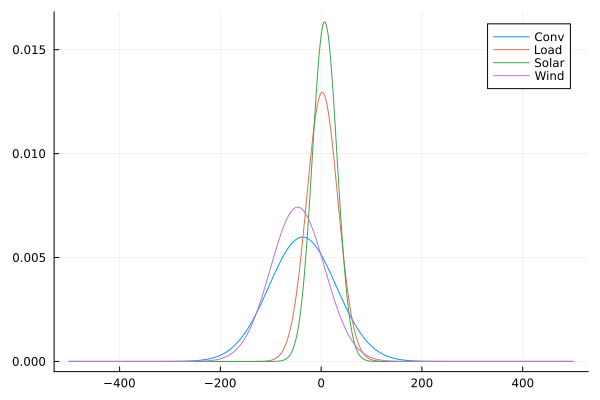

In [108]:
file = "data/Ecart 01 Janvier 2023.xlsx"
df = XLSX.readtable(file, "Sheet1") |> DataFrame
load_forecast_deviation = df[!, "Prévision Demande"]-df[!,"Réalisation Demande"]
solar_forecast_deviation = df[!, "Prévision Solaire"]-df[!,"Réalisation Solaire"]
wind_forecast_deviation = df[!, "Prévision éolienne"]-df[!,"Réalisation éolienne"]
#
load_error_dist = fit(Normal, load_forecast_deviation)
solar_error_dist = fit(Normal, solar_forecast_deviation)
wind_error_dist = fit(Stable, wind_forecast_deviation)
#
delta = 1e-1
big_grid = collect(range(-500, stop=500, step=delta))
#
pmf1 = pdf.(load_error_dist, big_grid)*delta #we sample by multiplying with interval width
println("Sum of load error pmf: $(sum(pmf1))")
#
pmf2 = pdf.(solar_error_dist, big_grid)*delta
println("Sum of solar error pmf: $(sum(pmf2))")
#
pmf3 = pdf.(wind_error_dist, big_grid)*delta #we sample by multiplying with interval width
println("Sum of wind error pmf: $(sum(pmf3))")
#
conv_pmf = centered_convolve(pmf1,pmf2)
println("Sum of convoluted pmf load and solar: $(sum(conv_pmf))")
#
conv_pmf = centered_convolve(conv_pmf,pmf3)
println("Sum of convoluted pmf with wind: $(sum(conv_pmf))")
#
conv_pmf = centered_convolve(conv_pmf,conv_pmf_fo)
println("Sum of convoluted pmf with outage: $(sum(conv_pmf))")
#
pdf1 = pmf1/delta
pdf2 = pmf2/delta
pdf3 = pmf3/delta
conv_pdf = conv_pmf/delta
println("Integration of convoluted pdf: $(trapz(big_grid, conv_pdf))")
#
plot(big_grid, conv_pdf, label="Conv")
plot!(big_grid, pdf1, label="Load")
plot!(big_grid, pdf2, label="Solar")
plot!(big_grid, pdf3, label="Wind")

In [102]:
trapz(big_grid, conv_pdf)

0.9999999999978767

### Dirac generator test

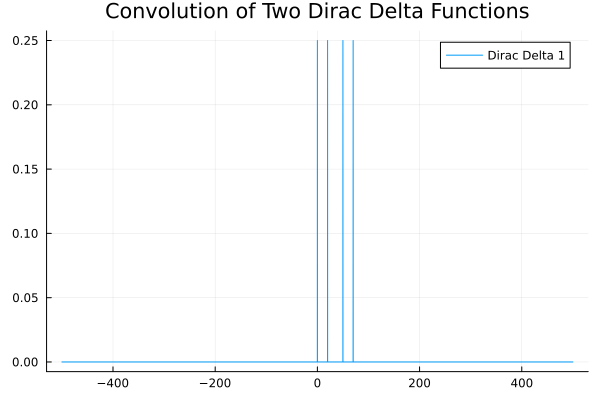

In [86]:
using DSP
# Parameters for the first Dirac delta
μ1 = 0   
μ2 = 20 
μ3 = 0 
μ4 = 50 
σ1 = σ2 = σ3 = σ4 = 0.00001 
desired_peak_value = 0.5

# Generate data for the first Dirac delta
dirac1 = Normal(μ1, σ1)
#stbl = convert(Stable, dirac1)
dirac2 = Normal(μ2, σ2)
dirac3 = Normal(μ3, σ3)
dirac4 = Normal(μ4, σ4)
#convv = convolve(dirac1, dirac2)
#convv = convolve(convv, dirac3)
#convv = convolve(convv, dirac4)
# Generate sample points
#x = range(-500, stop=500, length=1000)
x = collect(range(-500, stop=500, step=0.1))
#x1 = range(-500, stop=500, length=1999)
y1 = pdf.(dirac1, x)
y1 = (y1 ./ sum(y1)) *desired_peak_value
#
y2 = pdf.(dirac2, x)
y2 = (y2 ./ sum(y2)) *desired_peak_value
Y = y1+y2
#
y3 = pdf.(dirac3, x)
y3 = (y3 ./ sum(y3)) *desired_peak_value
#
y4 = pdf.(dirac4, x)
y4 = (y4 ./ sum(y4)) *desired_peak_value
Z = y3+y4
#
c = centered_convolve(Y, Z)
#c = c/sum(c)
#conv = pdf.(conv, x)
#return y1 , y2
# Convolve the two functions
#conv_result = convolve(dirac1, dirac2)  # 'shape=1' for 'same' convolution
#conv_result = pdf.(conv_result, x)
# Plot the results
plot(x, c, label="Dirac Delta 1", title="Convolution of Two Dirac Delta Functions")
#plot!(x, y2, label="Dirac Delta 2")
#plot!(x, conv_result, label="Convolution Result")